# Building a Neural Network to help recognise images of fruits and vegetables

#### Author: Radoslav Stefanov, Lecturer: Yordan Darakchiev

In [1]:
import mlflow
import mlflow.tensorflow
from mlflow.tracking import MlflowClient

import os
import random
import shutil

import tensorflow
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

import scipy
from keras.callbacks import EarlyStopping

In [2]:
# pip install mlflow

In [3]:
# import mlflow
# import mlflow.tensorflow

In [4]:
epochs = 30

In [6]:
client = MlflowClient()

# experiment_name="Fruit Neural Network experiment"

# new_experiment_fruit = client.create_experiment(experiment_name)

In [7]:
mlflow.start_run(experiment_id=914172388437437824)

# Log some of the parameters
mlflow.log_param("epochs", epochs)
mlflow.log_param("batch_size", 32)
mlflow.log_param("target_size", (64, 64))

2023/11/27 12:14:05 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



(64, 64)

## Data Selection 

The first dataset that has been chosen is created by Kritik Seth. He has gathered 36 different types of fruit and vegetables, each of which has approx. 100 examples and they are split into three folders/datasets with the following names and their distributions(%):
- train (80%)
- test (10%)
- validation (10%)

All of them will be used in this analysis to train the model well and later to validate its accuracy. Their metrics are saved in the Mlflow project run. 

Then, the second dataset consists of images of fresh and stale fruit, from which only the images of the fresh ones will be trained on a new neural network. Since there are some inconsistencies in the classes between the two datasets, the following pre-processing will be done: 
1. The second dataset contains only 6 classes of fruit and 12 folders (fresh/stale), they will be reduced to 5 classes of fresh fruit, as those are the fruit that can be found in the first dataset as well.
2. Then, the two datasets will be used together, by taking the train set of the first dataset as a validation set on the newly trained neural network. This will show how well the "fresh fruit" trained model classifies "fairly" new and different images of the same objects.

To see the data, find the sources in the [References](#References) section of this document. 

First, let's preprocess the first dataset, create the neural network and evaluate the results. 

## Data Preprocessing

### Use the ImageDataGenerator for data augmentation and preprocessing

In the parameters of the ImageDataGenerator class, we Normalize the pixel values to the range [0, 1] to allow for more efficient and consistent training of the model. The horizontal flip parameter has been set to True to increases the diversity of the training data. 

In [8]:
datagen = ImageDataGenerator(
    rescale=1./255, # Normalize the pixel values to the range [0, 1]
    horizontal_flip=True, # random flipping increases the diversity of the training data. 
)

### Load and preprocess the training set

When the data is being saved, it must be **at the same level** as the Jupyter Notebook and the name of the unzipped folder must be <b> fruits_veg <b>

In [9]:
current_directory = os.getcwd()

train_data_dir = current_directory + r"\fruits_veg\train"
# Example: C:\Users\user\Documents\folder1\folder2\fruits_veg\train

test_data_dir = current_directory + r"\fruits_veg\test"

validation_data_dir = current_directory + r"\fruits_veg\validation"

As it can be seen from the three generators below, the datagen variable containinig the ImageDataGenerator class has been configured to resize the images to 64x64 pixels, split the data into batches of 32 for better processing and the class_mode has been set to categorical to indicate that we are looking for specific categories.

In [10]:
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode="categorical"
)

Found 3115 images belonging to 36 classes.


Log the number of classes for the first dataset and the number of images in the train set

In [11]:
mlflow.log_param("First_dataset_num_classes", train_generator.num_classes)
mlflow.log_param("First_dataset_train_num_images", len(train_generator.filenames))

3115

### Load and preprocess the test set

It is used on a newly loaded model which does not have the saved weigths, it gets it from a special folder - checkpoints:

In [12]:
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(64, 64),
    batch_size=32, # it results to 97 batches, as there are 3115 images
    class_mode="categorical"
)

Found 359 images belonging to 36 classes.


Log the number of test samples:

In [13]:
mlflow.log_param("First_dataset_test_num_images", len(test_generator.filenames))

359

### Load and preprocess the validation set

In [14]:
validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(64, 64),
    batch_size=32, # it results to 97 batches, as there are 3115 images
    class_mode="categorical"
)

Found 351 images belonging to 36 classes.


Log the number of validation images:

In [15]:
mlflow.log_param("First_dataset_val_num_images", len(validation_generator.filenames))

351

## Model Selection

### Creation of the Model 

As already mentioned, the chosen model for the analysis is a Neural Network having 2 convolutional layers. The input requirements have been set in the creation of the first layer -> the input shape of each image needs to be 64 x 64 pixels with 3 channels. This is why we see the target_size of the preprocessed images to have the values (64, 64). 

The MaxPooling2D function applies a 2x2 processing of the images, so that the most important information about the image can be more easily extracted. The specifics of the model are also shown below.

The categorical_crossentropy loss function is used specifically for multi-class categorisation algorithms, this is why it is chosen in the compile function. 

The reason for choosing the metrics to be "accuracy" is the fact that it will be easier to interpret and the datasets are relatively evenly split between each other. 

In [16]:
def create_model():
    
    # Create the NN model: 
    model = Sequential()
    
    # Add a convolutional layer with ReLU activation
    model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    # Add another convolutional layer
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten the output and add a Dense layer with a ReLU activation
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    
    # Add the output layer 
    model.add(Dense(36, activation="softmax"))
    
    # Compile the model:
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"]
                 )
    return model

In [17]:
model = create_model()
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 64)              

### Set an early stopping mechanism for more effective tracking of the training process - convergence. 

In [18]:
# import scipy
# from keras.callbacks import EarlyStopping

In [19]:
early_stopping = EarlyStopping(monitor="val_accuracy",
                               patience=3
                              )

Log the early stopping parameters

In [20]:
mlflow.log_param("Early_stopping_patience", early_stopping.patience)
mlflow.log_param("Early_stopping_monitor", early_stopping.monitor)

'val_accuracy'

## Fitting the First Neural Network 

In [21]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

C:\Users\rstef\AppData\Local\Temp\ipykernel_12060\2803833002.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30


 3/97 [..............................] - ETA: 1:03 - loss: 3.7568 - accuracy: 0.0267

C:\Users\rstef\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


97/97 [==============================] - 104s 1s/step - loss: 3.3684 - accuracy: 0.0671 - val_loss: 2.8882 - val_accuracy: 0.1750
Epoch 2/30
97/97 [==============================] - 72s 749ms/step - loss: 2.7376 - accuracy: 0.2082 - val_loss: 2.2223 - val_accuracy: 0.3281
Epoch 3/30
97/97 [==============================] - 73s 752ms/step - loss: 2.3581 - accuracy: 0.3101 - val_loss: 1.7194 - val_accuracy: 0.5063
Epoch 4/30
97/97 [==============================] - 73s 751ms/step - loss: 2.1194 - accuracy: 0.3694 - val_loss: 1.4577 - val_accuracy: 0.5781
Epoch 5/30
97/97 [==============================] - 73s 750ms/step - loss: 1.8914 - accuracy: 0.4376 - val_loss: 1.2607 - val_accuracy: 0.6656
Epoch 6/30
97/97 [==============================] - 73s 749ms/step - loss: 1.6953 - accuracy: 0.5011 - val_loss: 1.2145 - val_accuracy: 0.6656
Epoch 7/30
97/97 [==============================] - 73s 756ms/step - loss: 1.5157 - accuracy: 0.5524 - val_loss: 1.0098 - val_accuracy: 0.6938
Epoch 8/30
9

#### Plot the training / test history to see how the losses diminish with each epoch

In [22]:
# import matplotlib.pyplot as pltjkk

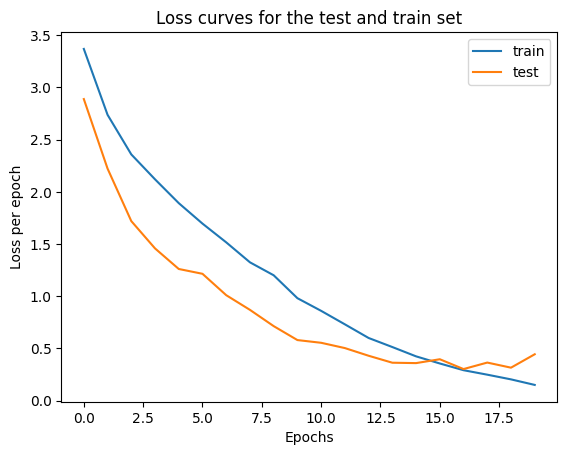

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel("Loss per epoch")
plt.xlabel("Epochs")
plt.title("Loss curves for the test and train set")
plt.legend()
plt.show()

#### Plot the training / test accuracy to see where the model converges: 

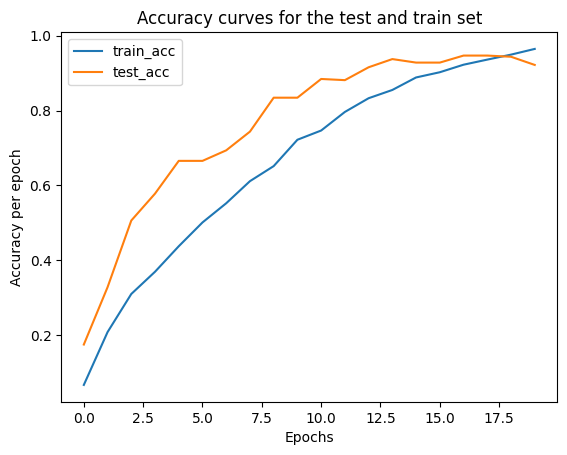

In [24]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='test_acc')
plt.ylabel("Accuracy per epoch")
plt.xlabel("Epochs")
plt.title("Accuracy curves for the test and train set")
plt.legend()
plt.show()

#### Save the weights of the entire model:


In [25]:
model.save_weights("./checkpoints/my_checkpoint")

#### Create a new model instance that does not have the knowledge obtained from the training set:


In [26]:
new_model = create_model()

#### Restore the weights and load them on to the new model:

In [27]:
new_model.load_weights("./checkpoints/my_checkpoint")

### Evaluate the new model with the origial weights: 


In [28]:
loss, acc = new_model.evaluate(test_generator, verbose=2)
print(loss, acc)

12/12 - 13s - loss: 0.4242 - accuracy: 0.9081 - 13s/epoch - 1s/step
0.4242260456085205 0.9080780148506165


### Logging results, metrics  

#### Log the loss and accuracy of the original model and the new one into MLflow

In [29]:
mlflow.log_metric("min_final_loss", round(min(history.history["val_loss"]), 4))
mlflow.log_metric("max_final_accuracy", round(max(history.history["val_accuracy"]), 4))

mlflow.log_metric("Validation_data_loss", round(loss, 4))
mlflow.log_metric("Validation_data_accuracy", round(acc, 4))

## Second dataset - Fresh and Stale fruit

As discussed in the beginning, the number of classes of fruit found in both datasets is 5. Therefore, first we have to take them from both datasets as follows:


### Split the Fresh dataset folders into training and test sets: 

In [30]:
# import os
# import random
# import shutil

In [31]:
def split_folder(input_folder, train_fresh_folder, test_fresh_folder, split_ratio, seed=21):
    # create the output folders:
    os.makedirs(train_fresh_folder, exist_ok=True)
    os.makedirs(test_fresh_folder, exist_ok=True)

    # List all files in the input folder
    all_files = os.listdir(input_folder)

    # calculate the split index 
    split_index = int(len(all_files) * split_ratio)

    # move the files to the train_fresh_folder and test_fresh_folder
    for i, file in enumerate(all_files):
        source_path = os.path.join(input_folder, file)
        if i < split_index:
            destination_path = os.path.join(train_fresh_folder, file)
        else:
            destination_path = os.path.join(test_fresh_folder, file)
        shutil.copy2(source_path, destination_path)

Find all the folders in the first dataset:

In [ ]:
train_data_list = os.listdir(train_data_dir)
train_data_list

Rename the fresh fruit folder names to match the classes from the first set

In [9]:
# Set the folder where to look for the FRESH data (depends how you name the folder in which the fresh/stale dataset is saved)
fresh_fruit_path = current_directory + r"\fresh_fruit"

In [ ]:
fresh_rm_str = "fresh_"

# List all items from the directory
fresh_fruit_list = os.listdir(fresh_fruit_path)

# Filter only the folders containing "fresh_" in their names, this needs to be removed, so that the classes match in each dataset
fresh_filtered_folders = [item for item in fresh_fruit_list if os.path.isdir(os.path.join(fresh_fruit_path, item)) and fresh_rm_str in item]

# Print the filtered folders:
print("Filtered folders:")
for folder in fresh_filtered_folders:
    print(folder)

In [ ]:
# Specify pattern to rename
old_text = "fresh_"
new_text = ""

# Rename those folders
for old_fresh_folder_name in fresh_filtered_folders:
    # Create the new folder names 
    new_fresh_folder_name = old_fresh_folder_name.replace(old_text, new_text)

    # Create the full paths 
    old_fresh_folder_path = os.path.join(fresh_fruit_path, old_fresh_folder_name)
    new_fresh_folder_path = os.path.join(fresh_fruit_path, new_fresh_folder_name)

    # Rename the folder
    os.rename(old_fresh_folder_path, new_fresh_folder_path)

print("Folders renamed successfully")

Delete the folders that begin with "stale_" - this will select only the folders which are not fresh, while if the condition is to select all the folders that do not have the phrase "fresh_", the command could delete all of the already corrected folders in case it is ran once more by mistake.


In [ ]:
stale_str = "stale_"

fresh_fruit_list

# Identify the folders that contain "stale_"
stale_folders_delete = [item for item in fresh_fruit_list if os.path.isdir(os.path.join(fresh_fruit_path, item)) and stale_str in item]

# Delete the identified folders 
for stale_folder in stale_folders_delete:
    stale_folder_path = os.path.join(fresh_fruit_path, stale_folder)

    try:
        # use shutil.rmtree() to delete the folder and its contents
        shutil.rmtree(stale_folder_path)
        print(f"Folder {stale_folder} deleted successfully.")
    except Exception as e:
        print(f"error in {stale_folder} deletion: {e}")

print("Deletion process completed.")

In [ ]:
fresh_data_list = os.listdir(fresh_fruit_path)
fresh_data_list

Find all of the classes/images that have representation in both datasets, i.e. the matching classes:

In [ ]:
matching_classes = [item for item in fresh_data_list if item in train_data_list]
matching_classes

Split the fresh fruit folders into train and test sets

In [ ]:
split_ratio = 0.8

for fruit in matching_classes:
    starting_folder = current_directory + r"\fresh_fruit\{}".format(fruit)
    train_folder = current_directory + r"\fresh_fruit\train\{}".format(fruit)
    test_folder = current_directory + r"\fresh_fruit\test\{}".format(fruit)
    split_folder(starting_folder, train_folder, test_folder, split_ratio)

### Load and process the fresh train set

In [32]:
train_fresh_data_dir = current_directory + r"\fresh_fruit\train"

In [33]:
train_fresh_generator = datagen.flow_from_directory(
    train_fresh_data_dir,
    target_size=(64, 64),
    batch_size=32, # resulting in 167 batches per epoch
    class_mode="categorical"
)

Found 5366 images belonging to 5 classes.


Record how many Fresh classes and train samples there are 

In [34]:
mlflow.log_param("Fresh_num_classes", train_fresh_generator.num_classes)
mlflow.log_param("Fresh_train_num_images", len(train_fresh_generator.filenames))

5366

### Load and process the fresh test set

In [35]:
test_fresh_data_dir = current_directory + r"\fresh_fruit\test"

In [36]:
test_fresh_generator = datagen.flow_from_directory(
    test_fresh_data_dir,
    target_size=(64, 64),
    batch_size=32, 
    class_mode="categorical"
)

Found 1345 images belonging to 5 classes.


Record the fresh test samples as well:

In [37]:
mlflow.log_param("Fresh_test_num_images", len(test_fresh_generator.filenames))

1345

### Creation of the Fresh Model

It is almost the same as the first model, with one little difference - the number of classes is different, in this case it is <b>5</b>. Therefore, the output layer needs to be with the same number of end nodes. 

In [38]:
def create_fresh_model():
    
    # Create the NN model: 
    model = Sequential()
    
    # Add a convolutional layer with ReLU activation
    model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    # Add another convolutional layer
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten the output and add a Dense layer with a ReLU activation
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    
    # Add the output layer 
    model.add(Dense(5, activation="softmax"))
    
    # Compile the model:
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"]
                 )
    return model


In [39]:
fresh_model = create_fresh_model()
# fresh_model.summary()

In [40]:
fresh_history = fresh_model.fit_generator(
    train_fresh_generator,
    steps_per_epoch=train_fresh_generator.samples // train_fresh_generator.batch_size,
    epochs = epochs,
    validation_data = test_fresh_generator,
    validation_steps = test_fresh_generator.samples // test_fresh_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/30


C:\Users\rstef\AppData\Local\Temp\ipykernel_12060\4119488398.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fresh_history = fresh_model.fit_generator(


167/167 [==============================] - 24s 142ms/step - loss: 0.2864 - accuracy: 0.9034 - val_loss: 0.1705 - val_accuracy: 0.9464
Epoch 2/30
167/167 [==============================] - 23s 139ms/step - loss: 0.0901 - accuracy: 0.9717 - val_loss: 0.1769 - val_accuracy: 0.9129
Epoch 3/30
167/167 [==============================] - 24s 144ms/step - loss: 0.0485 - accuracy: 0.9833 - val_loss: 0.1196 - val_accuracy: 0.9442
Epoch 4/30
167/167 [==============================] - 24s 141ms/step - loss: 0.0211 - accuracy: 0.9944 - val_loss: 0.0408 - val_accuracy: 0.9859
Epoch 5/30
167/167 [==============================] - 24s 142ms/step - loss: 0.0198 - accuracy: 0.9938 - val_loss: 0.0271 - val_accuracy: 0.9881
Epoch 6/30
167/167 [==============================] - 23s 139ms/step - loss: 0.0118 - accuracy: 0.9966 - val_loss: 0.0314 - val_accuracy: 0.9881
Epoch 7/30
167/167 [==============================] - 23s 140ms/step - loss: 0.0178 - accuracy: 0.9953 - val_loss: 0.0768 - val_accuracy: 0.9

### Fresh Visualisations after training with own data


#### Loss curve

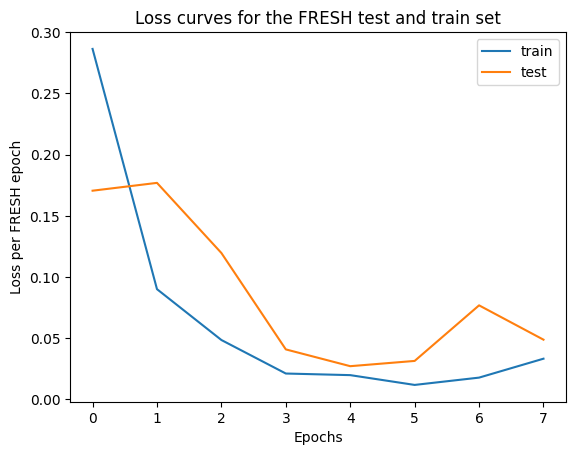

In [41]:
plt.plot(fresh_history.history['loss'], label='train')
plt.plot(fresh_history.history['val_loss'], label='test')
plt.ylabel("Loss per FRESH epoch")
plt.xlabel("Epochs")
plt.title("Loss curves for the FRESH test and train set")
plt.legend()
plt.show()

### Accuracy curve

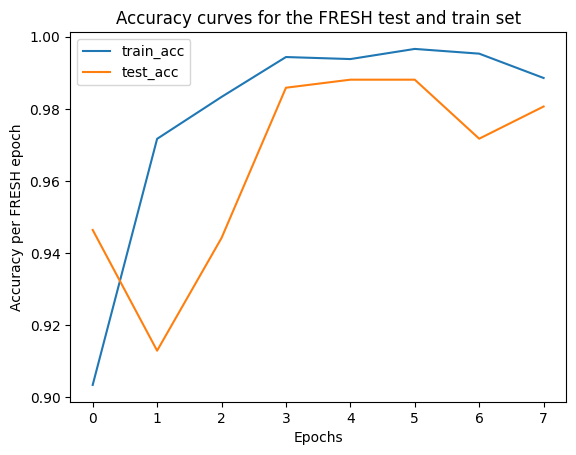

In [42]:
plt.plot(fresh_history.history['accuracy'], label='train_acc')
plt.plot(fresh_history.history['val_accuracy'], label='test_acc')
plt.ylabel("Accuracy per FRESH epoch")
plt.xlabel("Epochs")
plt.title("Accuracy curves for the FRESH test and train set")
plt.legend()
plt.show()

### Save the weights of the entire Fresh model:

In [43]:
fresh_model.save_weights("./checkpoints/fresh_checkpoint")

#### Create a new model instance that does not have the knowledge obtained from the training set:

**This is to be used to directly load the trained model:**

In [44]:
restore_fresh_model = create_fresh_model()

#### Restore the weights and load them on to the new fresh model:

In [45]:
restore_fresh_model.load_weights("./checkpoints/fresh_checkpoint")

### Logging Fresh results, metrics  

#### Log the loss and accuracy of the fresh model 

In [46]:
mlflow.log_metric("min_fresh_loss", round(min(fresh_history.history["val_loss"]), 4))
mlflow.log_metric("max__fresh_accuracy", round(max(fresh_history.history["val_accuracy"]), 4))

### Training the model further on the train set of the first model and then test with the TEST set of the first model:



#### Make a copy of the folders from the first dataset that match the new / fresh classes 

In [47]:
train_data_dir

'C:\\Users\\rstef\\Documents\\!SoftUni_ML\\ML_full_project\\fruits_veg\\train'

In [48]:
fruit_veg_path = current_directory + r"\fruits_veg"

train_5_cls_folder_name = "train_5_classes"

new_5_cls_train_path = os.path.join(fruit_veg_path, train_5_cls_folder_name)

print(new_5_cls_train_path)

for item in matching_classes:
    source_path = os.path.join(train_data_dir, item)
    destination_path = os.path.join(new_5_cls_train_path, item)
    shutil.copytree(source_path, destination_path)

C:\Users\rstef\Documents\!SoftUni_ML\ML_full_project\fruits_veg\train_5_classes


NameError: name 'matching_classes' is not defined

And from the test folder:

In [ ]:
test_data_dir

In [ ]:
test_5_cls_folder_name = "test_5_classes"

new_5_cls_test_path = os.path.join(fruit_veg_path, test_5_cls_folder_name)

print(new_5_cls_test_path)

for item in matching_classes:
    source_path = os.path.join(test_data_dir, item)
    destination_path = os.path.join(new_5_cls_test_path, item)
    shutil.copytree(source_path, destination_path)

In [49]:
train_5_classes_dir = current_directory + r"\fruits_veg\train_5_classes"

In [50]:
train_5_classes_generator = datagen.flow_from_directory(
    train_5_classes_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode="categorical"
)

Found 393 images belonging to 5 classes.


Log the number of images that is filtered out of the first dataset's train set

In [51]:
mlflow.log_param("Train_5_classes_num_images", len(train_5_classes_generator.filenames))

393

In [52]:
fresh_history = fresh_model.fit_generator(
    train_fresh_generator,
    steps_per_epoch=train_fresh_generator.samples // train_fresh_generator.batch_size,
    epochs = epochs,
    validation_data = train_5_classes_generator,
    validation_steps = train_5_classes_generator.samples // train_5_classes_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/30


C:\Users\rstef\AppData\Local\Temp\ipykernel_12060\4086946765.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fresh_history = fresh_model.fit_generator(


167/167 [==============================] - 28s 166ms/step - loss: 0.0053 - accuracy: 0.9983 - val_loss: 8.5331 - val_accuracy: 0.3828
Epoch 2/30
167/167 [==============================] - 28s 167ms/step - loss: 0.0238 - accuracy: 0.9908 - val_loss: 8.5039 - val_accuracy: 0.4141
Epoch 3/30
167/167 [==============================] - 28s 168ms/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 9.8421 - val_accuracy: 0.3672
Epoch 4/30
167/167 [==============================] - 28s 170ms/step - loss: 6.0019e-04 - accuracy: 1.0000 - val_loss: 10.1316 - val_accuracy: 0.3932
Epoch 5/30
167/167 [==============================] - 28s 168ms/step - loss: 0.0606 - accuracy: 0.9820 - val_loss: 5.7716 - val_accuracy: 0.4062


### Fresh Visualisations after training with first dataset's training data

#### Loss curve

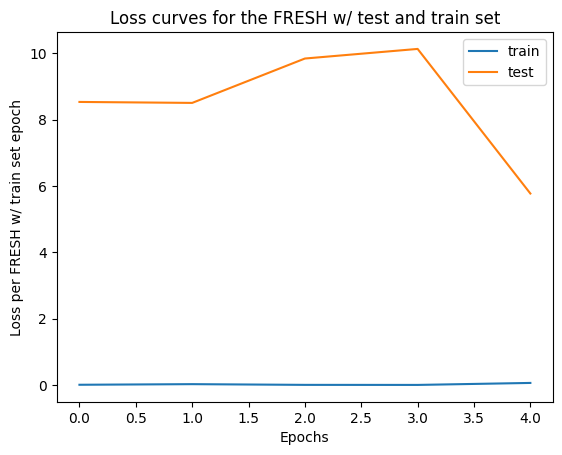

In [53]:
plt.plot(fresh_history.history['loss'], label='train')
plt.plot(fresh_history.history['val_loss'], label='test')
plt.ylabel("Loss per FRESH w/ train set epoch")
plt.xlabel("Epochs")
plt.title("Loss curves for the FRESH w/ test and train set")
plt.legend()
plt.show()

#### Accuracy curve

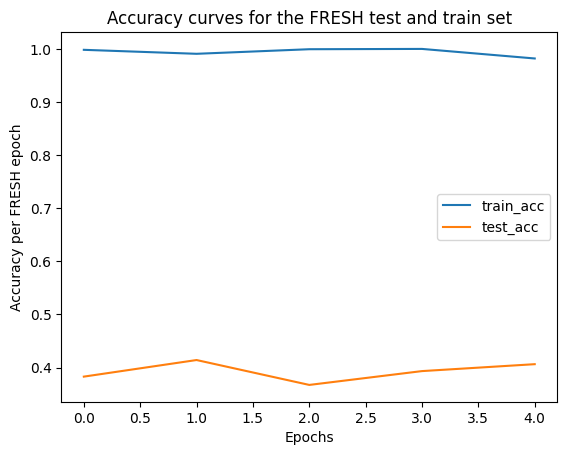

In [54]:
plt.plot(fresh_history.history['accuracy'], label='train_acc')
plt.plot(fresh_history.history['val_accuracy'], label='test_acc')
plt.ylabel("Accuracy per FRESH epoch")
plt.xlabel("Epochs")
plt.title("Accuracy curves for the FRESH test and train set")
plt.legend()
plt.show()

### Logging Fresh results, metrics  

#### Log the loss and accuracy of the fresh model 

In [55]:
mlflow.log_metric("Min_loss_fresh_with_train_5_classes_loss", round(min(fresh_history.history["val_loss"]), 4))
mlflow.log_metric("Max_fresh_with_train_5_classes_accuracy", round(max(fresh_history.history["val_accuracy"]), 4))

### Create a filtered test set from the first test dataset as validation and evaluation of the fresh model: 

In [56]:
test_5_classes_dir = current_directory + r"\fruits_veg\test_5_classes"

In [57]:
test_5_classes_generator = datagen.flow_from_directory(
    test_5_classes_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode="categorical"
)

Found 49 images belonging to 5 classes.


Log the number of images that is filtered from the first dataset's test set

In [58]:
mlflow.log_param("Test_5_classes_num_images", len(test_5_classes_generator.filenames))

49

#### Evaluate the fresh Model's performance when presented with new test data

In [59]:
fresh_loss, fresh_acc = fresh_model.evaluate(test_5_classes_generator, verbose=2)
print(fresh_loss, fresh_acc)

2/2 - 1s - loss: 4.0335 - accuracy: 0.5510 - 1s/epoch - 714ms/step
4.0334954261779785 0.5510203838348389


Log the metrics showing how well the fresh model managed to classify the newly presented images. 

In [60]:
mlflow.log_metric("Fresh_model_new_data_test_loss", round(fresh_loss, 4))
mlflow.log_metric("Fresh_model_new_data_test_accuracy", round(fresh_acc,4))

As we can see, the training of the Neural network firstly on a split sample of its dataset reveals a high accuracy rates, which could mean that the model is overfitting the data. Then, the model is once again trained on the train samples from the first dataset to see if the new information would be accepted and learned by the model. It appears that this is not the case, as the accuracy gets "stuck" at 40%. When evaluating the model on the test set from the first dataset, the results are slightly more accurate, however, they still cannot pass above the 50% mark. 

Given this large dataset of clearly defined images, it is interesting to notice a sort of "inability" of the model to learn new information even if the images are slightly more different than the initial samples. To cope with those issues, a further parameter tuning can be performed, so that the estimators/weights on the nodes of the neural network better predict the type of fruit 

### Save the weights of the entire fresh model:


In [61]:
fresh_model.save_weights("./checkpoints/my_fresh_final_checkpoint")

#### Create a new model instance that does not have the knowledge obtained from the training set:

**This is to be used to directly load the trained model:**

In [62]:
restore_fresh_model = create_fresh_model()

#### Restore the weights and load them on to the new fresh model:

In [ ]:
restore_fresh_model.load_weights("./checkpoints/my_fresh_final_checkpoint")

## Save the models and stop the Mlflow server run

In [63]:
mlflow.tensorflow.save_model(model, "First model")
mlflow.tensorflow.save_model(fresh_model, "Fresh model")

mlflow.end_run()

2023/11/27 13:52:43 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\rstef\Documents\!SoftUni_ML\ML_full_project\First model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\rstef\Documents\!SoftUni_ML\ML_full_project\First model\data\model\assets
2023/11/27 13:52:47 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\rstef\Documents\!SoftUni_ML\ML_full_project\First model, flavor: tensorflow), fall back to return ['tensorflow==2.15.0']. Set logging level to DEBUG to see the full traceback.
C:\Users\rstef\AppData\Local\Programs\Python\Python310\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2023/11/27 13:52:47 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\rstef\Documents\!SoftUni_ML\ML_full_project\Fresh model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\rstef\Documents\!SoftUni_ML\ML_full_project\Fresh model\data\model\assets
2023/11/27 13:52:48 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\rstef\Documents\!SoftUni_ML\ML_full_project\Fresh model, flavor: tensorflow), fall back to return ['tensorflow==2.15.0']. Set logging level to DEBUG to see the full traceback.


## Conclusion and discussion on the results.

As it can be seen from the graphs and from the model fitting of the training data, the neural network is able to learn the dependencies and patterns in the images in less than 25 epochs, when the allowed maximum is 30. The number of the epochs could potentially be improved if the number of images is increased and then more batches will be created with each epoch. Still, this experiment aims to show the power of the Neural Network - the dataset has 36 classes which are contained within no more than 3500 images and the model was already able to differentiate each fruit or vegetable from the validation set with an accuracy of over 90% (92% to be exact). 

In the second part of this paper, we examined another dataset with a much larger sample size for a limited number of the classes from the first dataset. The neural network managed to converge within just 4 epochs and it managed to achieve a high accuracy score above 95%. This could be explained by the similarity of the train and test images. When presented with another set of images - the train set of the first dataset, the model finds it hard to differentiate the classes and the accuracy drops to approximately 40%. The test set performed generally better reaching about 50%, but still it is far from the initial accuracy. One of the reasons for this event could be overfitting of the model to the test data, which limits the ability of the model to generalise its predictions. 

Therefore, this piece of research could be extended with more samples and more classes for the creation of an even more complex model, but the initial results clearly show that the model is capable of making almost perfect accurate predictions. The second data reveals another side of the algorithm - presenting slightly different sample data for validation makes it difficult for the model to differentiate the new classes. Consequently, hyperparameter tuning can be undertaken to adjust the model accordingly.



## References


1. The data used for training the original Neural Network has been obtained from Kaggle from the following source: <br>
Kritik Seth, "Fruits and Vegetables Image Recognition Dataset," Kaggle 2020 https://www.kaggle.com/kritikseth/fruit-and-vegetable-image-recognition

2. The validation data was taken from: <br>
Fresh and Stale Images of Fruits and Vegetables: https://www.kaggle.com/datasets/raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables/data



## Appendix

In [ ]:
# # Template for logging parameters/metrics
# mlflow.start_run()

# # mlflow.log_metric("First_dataset_num_classes", train_generator.num_classes)
# # mlflow.log_metric("First_dataset_val_num_images", len(validation_generator.filenames))
# mlflow.log_metric("Early_stopping_patience", early_stopping.patience)
# mlflow.log_param("Early_stopping_monitor", early_stopping.monitor)

# mlflow.end_run()